In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno_interp import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(alpha_aux=[Normal(0,2), Normal(0,2)], aug_alpha=True, n_steps=10),
               LossTracker(),SaveBest('weights/best_ii3a.h5'),EarlyStopping(10)])

1: Train=647.4404583740235 Valid=546.065146484375
2: Train=514.8674945068359 Valid=497.90756958007813
3: Train=480.27686920166013 Valid=476.7560784912109
4: Train=459.9389630126953 Valid=466.82455078125
5: Train=447.6855227661133 Valid=449.68537048339846
6: Train=433.35035034179685 Valid=437.26714965820315
7: Train=423.12608337402344 Valid=429.8510986328125
8: Train=413.06890258789065 Valid=422.2157208251953
9: Train=403.0371566772461 Valid=414.0726300048828
10: Train=394.8305145263672 Valid=402.61518432617186
11: Train=384.53515625 Valid=391.61661865234373
12: Train=373.6812969970703 Valid=382.080908203125
13: Train=366.7013186645508 Valid=375.78003356933596
14: Train=358.68397735595704 Valid=362.46240783691405
15: Train=349.8294369506836 Valid=357.74835876464846
16: Train=346.9781687927246 Valid=353.260498046875
17: Train=342.9920346069336 Valid=351.07714477539065
18: Train=339.49476959228514 Valid=348.93467712402344
19: Train=337.80141204833984 Valid=346.2932983398438
20: Train=335.

156: Train=297.4619174194336 Valid=310.79557250976563
157: Train=297.6957795715332 Valid=311.28659790039063
158: Train=297.672225189209 Valid=311.1597674560547
159: Train=296.51717041015627 Valid=310.62536682128905
160: Train=296.79619079589844 Valid=310.7371649169922
161: Train=296.3776513671875 Valid=310.28216064453125
162: Train=295.92712692260744 Valid=309.91545959472654
163: Train=296.5185824584961 Valid=310.05647644042966
164: Train=295.3980599975586 Valid=309.20814697265627
165: Train=296.23863403320314 Valid=309.91217224121095
166: Train=295.6846565246582 Valid=309.75676818847654
167: Train=296.5080682373047 Valid=309.2064407348633
168: Train=295.8790151977539 Valid=309.3359753417969
169: Train=294.628586730957 Valid=308.8211938476563
170: Train=295.27509353637697 Valid=309.55991821289064
171: Train=295.6507757568359 Valid=309.6193084716797
172: Train=295.57894744873045 Valid=309.0970538330078
173: Train=294.792859954834 Valid=309.4139801025391
174: Train=295.2310041809082 Vali

In [8]:
model.save('weights/Inferno_Test_interp_bm3a.h5')

In [9]:
model.load('weights/Inferno_Test_interp_bm3a.h5')

# Results

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,5,1.0
1,6,1.0
2,4,1.0
3,8,1.0
4,6,1.0


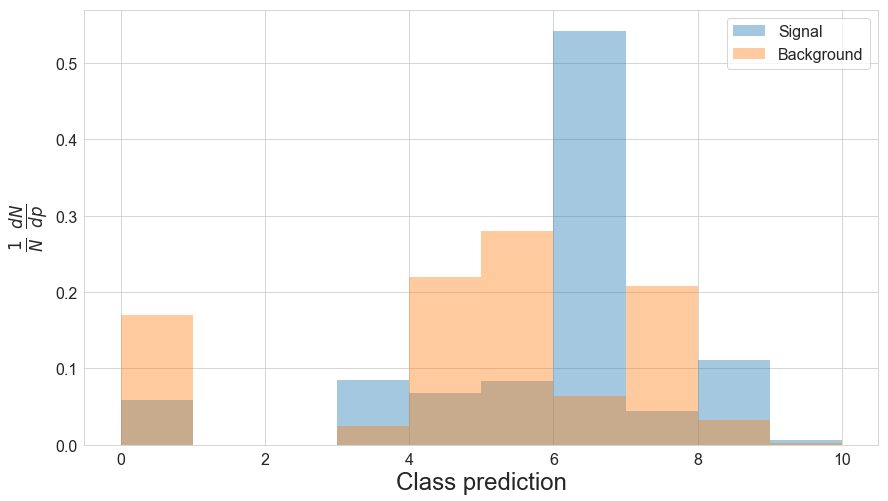

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [13]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,5,1.0,5
1,6,1.0,6
2,4,1.0,4
3,8,1.0,8
4,6,1.0,6


In [15]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [17]:
f_s, f_b

(tensor([5.9034e-02, 2.0000e-13, 2.0000e-13, 8.5132e-02, 6.8202e-02, 8.3800e-02,
         5.4242e-01, 4.3634e-02, 1.1145e-01, 6.3220e-03]),
 tensor([1.6996e-01, 2.0000e-13, 2.0000e-13, 2.4200e-02, 2.1967e-01, 2.7955e-01,
         6.3750e-02, 2.0800e-01, 3.3090e-02, 1.7740e-03]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([1.7291e+02, 2.1000e-10, 2.1000e-10, 2.8457e+01, 2.2308e+02, 2.8374e+02,
         9.0871e+01, 2.1019e+02, 3.8663e+01, 2.0901e+00]), tensor(1050.))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([26.27852249, 26.14121437, 26.00926208, 25.88289642, 25.76170921,
       25.64618301, 25.53554535, 25.43009758, 25.33027077, 25.23513412,
       25.14464378, 25.05950165, 24.9793911 , 24.90365982, 24.83317566,
       24.76672363, 24.70507812, 24.64837646, 24.59592628, 24.54817581,
       24.50451851, 24.46521568, 24.43041992, 24.39996719, 24.37366486,
       24.35144806, 24.33337784, 24.31964684, 24.30959702, 24.30402756,
       24.30163765, 24.30385971, 24.309412  , 24.31918716, 24.33252907,
       24.34977341, 24.37065887, 24.39530945, 24.4233799 , 24.45491028,
       24.49039459, 24.52936363, 24.57162857, 24.61730766, 24.66663551,
       24.71903229, 24.77497101, 24.83402634, 24.89660835, 24.96250153,
       25.03148842, 25.10348892, 25.17910957, 25.25744629, 25.33892059,
       25.42381477, 25.51128769, 25.60185242, 25.69566727, 25.79206467,
       25.89195442])

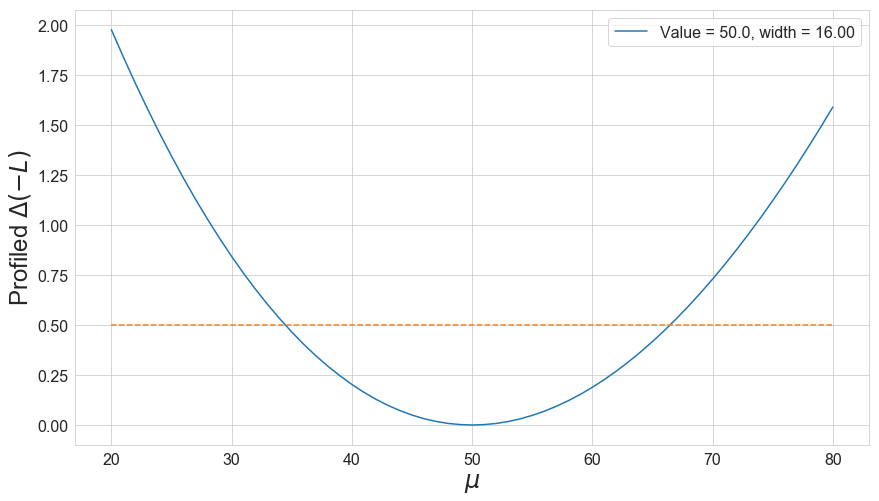

In [21]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [22]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [23]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [24]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,5,1.0,5,5,5,5,5,5,5,5,5,5,5
1,6,1.0,6,6,6,6,6,6,6,6,6,6,6
2,4,1.0,4,4,4,4,4,4,4,4,4,4,4
3,8,1.0,8,8,8,8,8,8,8,8,8,8,8
4,6,1.0,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,7,0.0,7,7,7,7,7,7,7,7,7,7,7
999996,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999997,4,0.0,4,4,4,4,4,4,4,4,4,4,4
999998,0,0.0,0,0,0,0,0,0,0,0,0,0,0


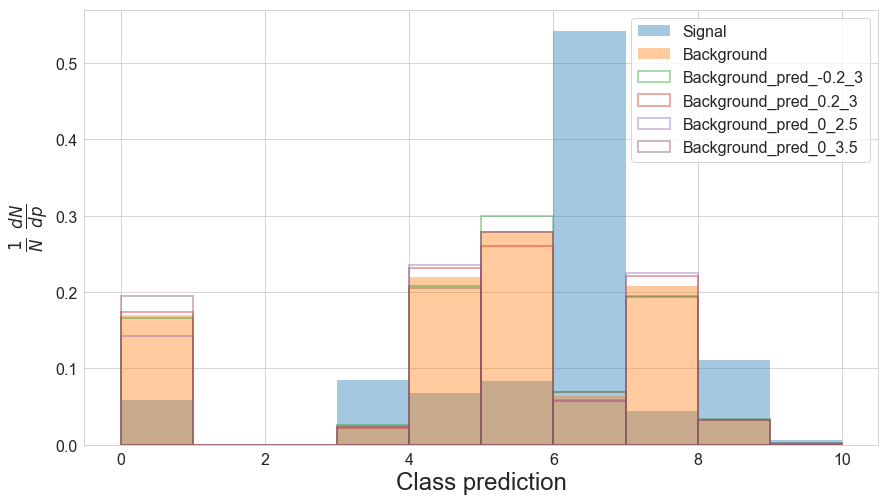

In [25]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([1.3840e-01, 2.0000e-13, 2.0000e-13, 2.6900e-02, 2.2283e-01, 2.9959e-01,
        6.4992e-02, 2.1124e-01, 3.3724e-02, 2.3320e-03])
tensor([1.6578e-01, 2.0000e-13, 2.0000e-13, 2.6042e-02, 2.0752e-01, 3.0003e-01,
        6.9686e-02, 1.9463e-01, 3.4268e-02, 2.0440e-03])
tensor([1.9070e-01, 2.0000e-13, 2.0000e-13, 2.5072e-02, 1.9362e-01, 2.9977e-01,
        7.4528e-02, 1.8020e-01, 3.4276e-02, 1.8280e-03])
tensor([1.4258e-01, 2.0000e-13, 2.0000e-13, 2.5058e-02, 2.3498e-01, 2.7911e-01,
        5.9056e-02, 2.2461e-01, 3.2546e-02, 2.0620e-03])
tensor([1.6996e-01, 2.0000e-13, 2.0000e-13, 2.4200e-02, 2.1967e-01, 2.7955e-01,
        6.3750e-02, 2.0800e-01, 3.3090e-02, 1.7740e-03])
tensor([1.9488e-01, 2.0000e-13, 2.0000e-13, 2.3230e-02, 2.0577e-01, 2.7930e-01,
        6.8592e-02, 1.9357e-01, 3.3098e-02, 1.5580e-03])
tensor([1.4606e-01, 2.0000e-13, 2.0000e-13, 2.2860e-02, 2.4737e-01, 2.5929e-01,
        5.3152e-02, 2.3808e-01, 3.1390e-02, 1.7920e-03])
tensor([1.7344e-01, 2.0000e-13, 2.0000e-1

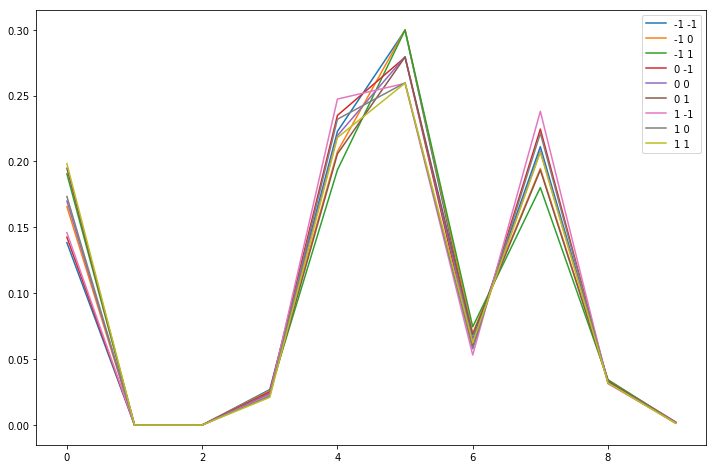

In [26]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [27]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [28]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [29]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [30]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [31]:
nll = to_np(nll)

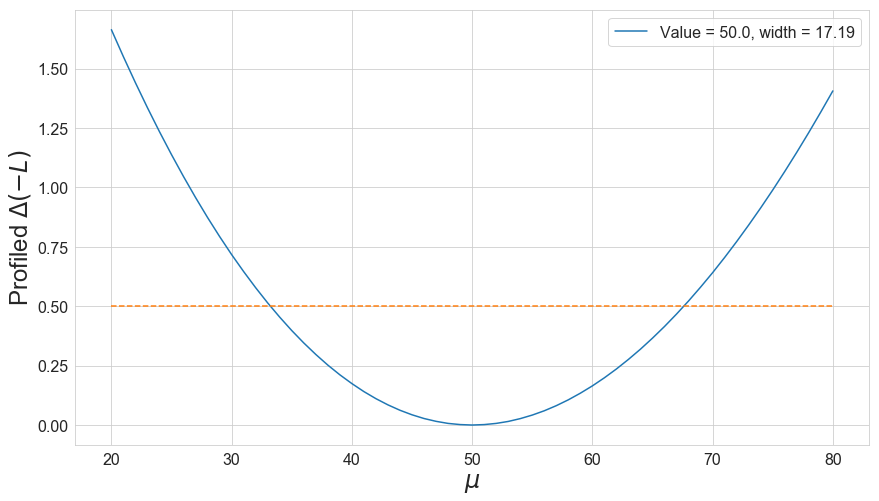

In [32]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [33]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [34]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [35]:
nll = to_np(nll)

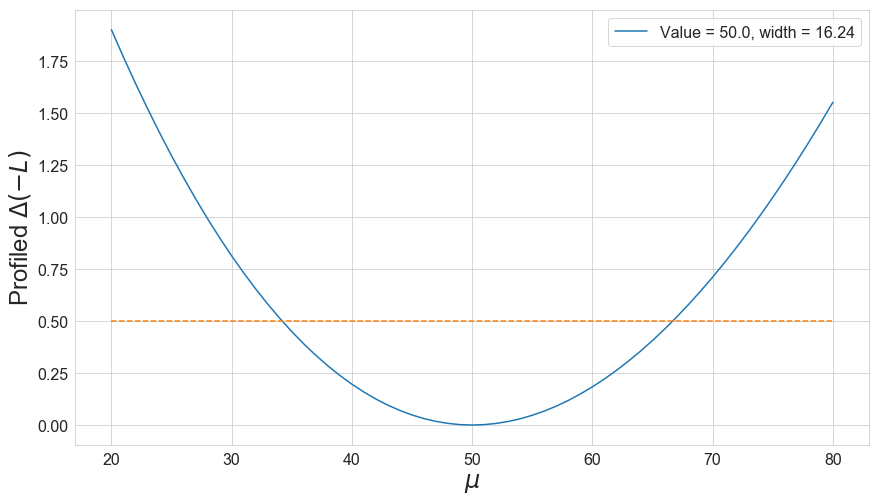

In [36]:
plot_likelihood(nll-nll.min())

## BM 2

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [38]:
nll = to_np(nll)

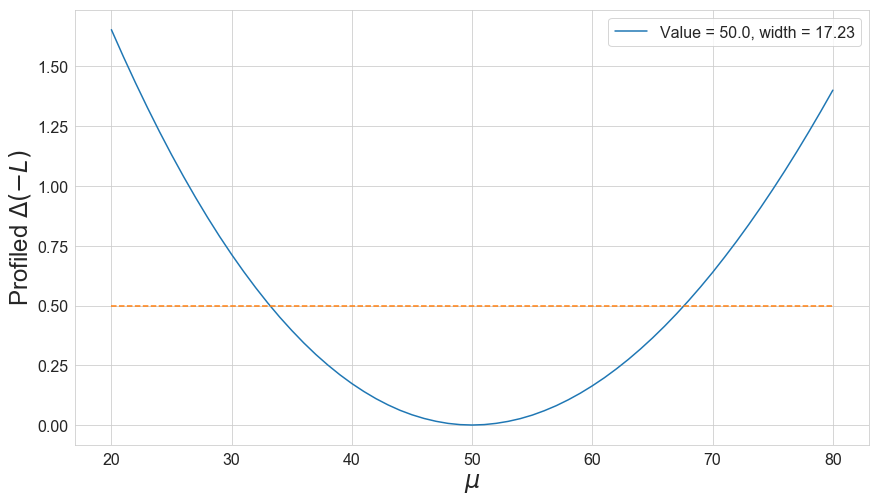

In [39]:
plot_likelihood(nll-nll.min())

## BM 3

In [40]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [41]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [42]:
nll = to_np(nll)

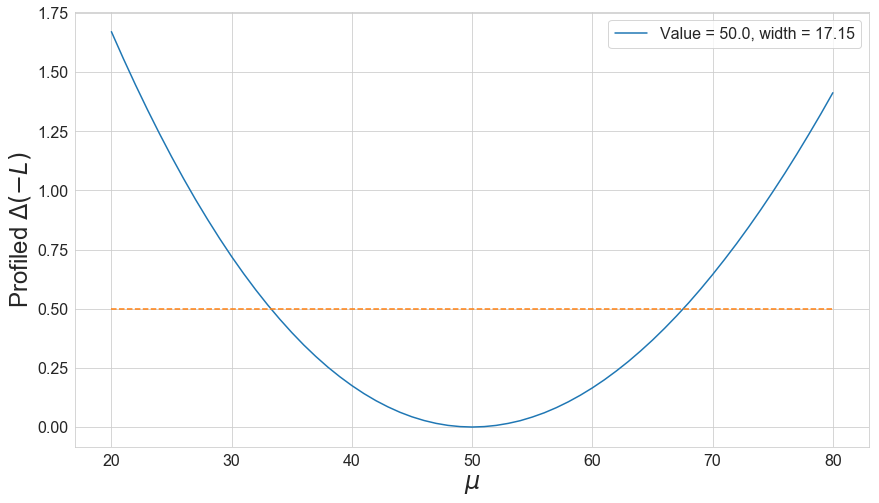

In [43]:
plot_likelihood(nll-nll.min())

## BM 4

In [44]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [45]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3575,  0.0639, 25.5612])
Linear regime: Mu 21.0, alpha tensor([-0.3446,  0.0615, 24.6370])
Linear regime: Mu 22.0, alpha tensor([-0.3317,  0.0591, 23.7183])
Linear regime: Mu 23.0, alpha tensor([-0.3190,  0.0567, 22.8049])
Linear regime: Mu 24.0, alpha tensor([-0.3063,  0.0543, 21.8969])
Linear regime: Mu 25.0, alpha tensor([-0.2937,  0.0520, 20.9941])
Linear regime: Mu 26.0, alpha tensor([-0.2811,  0.0497, 20.0966])
Linear regime: Mu 27.0, alpha tensor([-0.2686,  0.0474, 19.2043])
Linear regime: Mu 28.0, alpha tensor([-0.2562,  0.0451, 18.3171])
Linear regime: Mu 29.0, alpha tensor([-0.2439,  0.0429, 17.4349])
Linear regime: Mu 30.0, alpha tensor([-0.2316,  0.0406, 16.5578])
Linear regime: Mu 31.0, alpha tensor([-0.2194,  0.0384, 15.6857])
Linear regime: Mu 32.0, alpha tensor([-0.2073,  0.0362, 14.8185])
Linear regime: Mu 33.0, alpha tensor([-0.1952,  0.0341, 13.9562])
Linear regime: Mu 34.0, alpha tensor([-0.1832,  0.0319, 13.0987])
Linear reg

In [46]:
nll = to_np(nll)

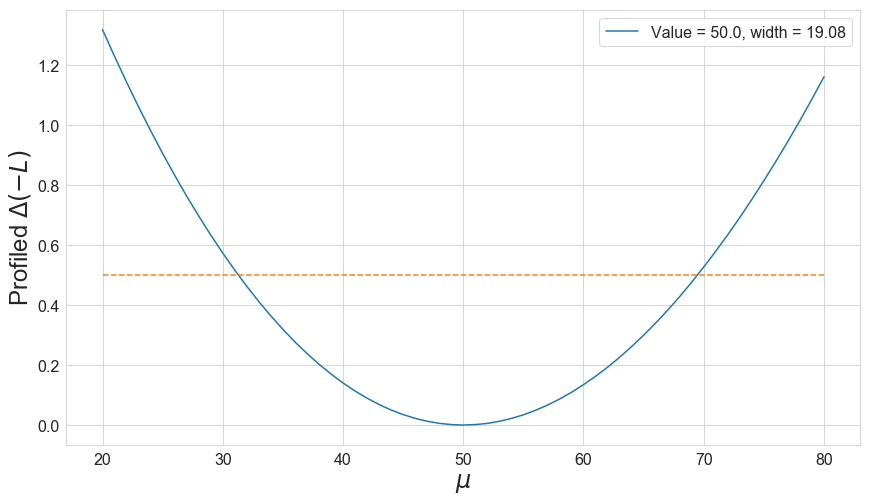

In [47]:
plot_likelihood(nll-nll.min())